In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-09 17:12:23.744253: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-09 17:12:23.775309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-11-09 17:12:23.775508: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-09 17:12:23.776960: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-09 17:12:23.778648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-09 17:12:23.778862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [3]:
stream = "gd1_tail"

In [4]:
df, file = load_file(stream = stream, percent_bkg = 25)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 0.154% of the dataset.


In [5]:
# a = np.load('../ViaMachinae/knownstreams.npz')
# stream = pd.DataFrame(a['Gaia3'][:,[3,2,1,0,4,5]], columns = ['μ_δ','μ_α','δ','α','mag','color'])
# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.scatter(stream.α,stream.δ,color='black',s=0.2, label="Stream")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

In [6]:
# ### Get offsets 
# pieces = file.split('_')
# for piece in pieces:
#     if piece.startswith("l"): 
#         l = float(piece[1:])
#     elif piece.startswith("b"): 
#         b = float(piece[1:])
# print(l,b)

# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.hist2d(df.α,df.δ,bins=50)
# # plt.colorbar()
# plt.scatter(stream.α-l,stream.δ-b,color='gray',s=0.2, label="Stream")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

In [7]:
# plt.figure(figsize=(3.7,3), dpi=150, tight_layout=True)
# plt.hist2d(df.α,df.δ,bins=50)
# plt.colorbar()
# # plt.scatter(jhelum.α-l,jhelum.δ+b,color='white',s=0.2, label="Jhelum")
# plt.xlabel(r"$\alpha$ [\textdegree]")
# plt.ylabel(r"$\delta$ [\textdegree]");

### Optional: Exclude a hotspot

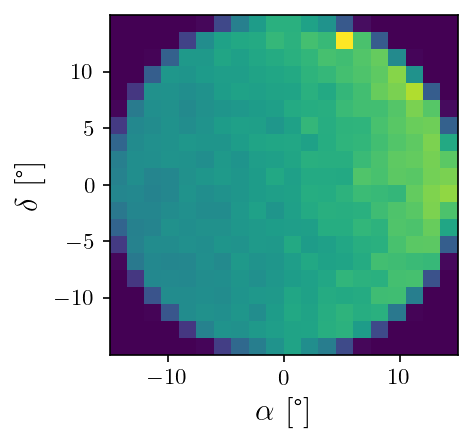

In [8]:
plt.figure(figsize=(3,3),dpi=150)
hist = plt.hist2d(df.α, df.δ, bins=20)
plt.xlabel(r'$\alpha$ [\textdegree]');
plt.ylabel(r'$\delta$ [\textdegree]');

In [9]:
# Get indices for hotspot bin to exclude
i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# Exclude this bin based on bin edges 
df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
         (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# Redefine dataframe
df = df2

99.5% of the dataset remains.


### Prepare datasets for training

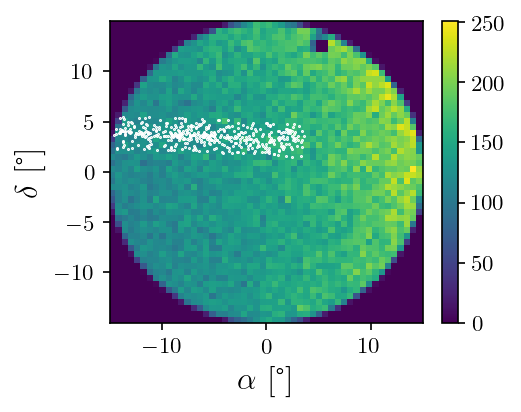

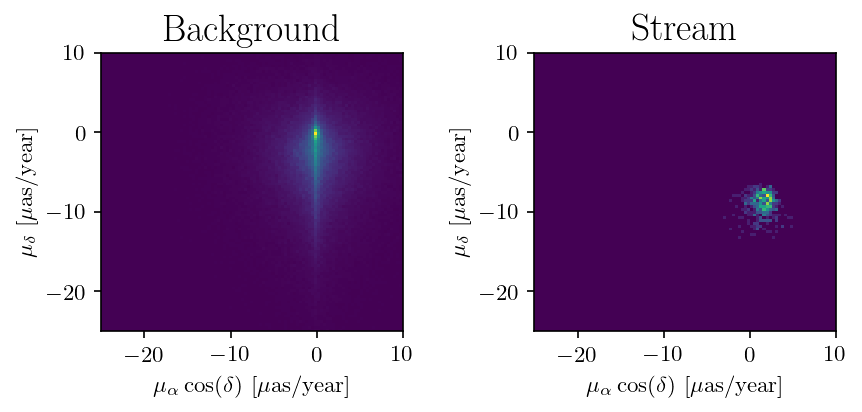

In [10]:
visualize_stream(df, show_stream=True)

Text(0.5, 0, 'GD1 Tail')

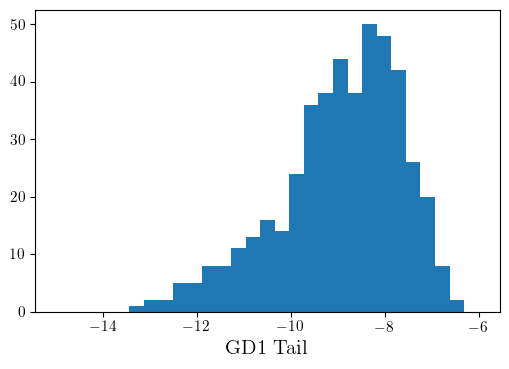

In [11]:
plt.hist(df[df.stream].μ_δ, bins=np.linspace(-15,-6,30));
plt.xlabel('GD1 Tail')

Sideband region: [-15,-5]
Signal region: [-11,-7]
Total counts: SR = 38,991, SB = 50,599
Signal region has 404 stream and 38,587 bkg events (1.05%).
Sideband region has 57 stream and 50,542 bkg events (0.11%).
f_sig = 9.3X f_sideband.


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


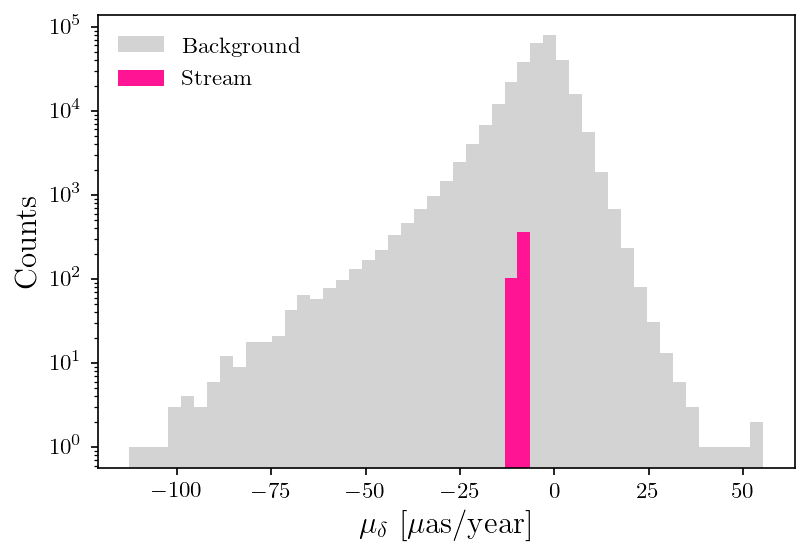

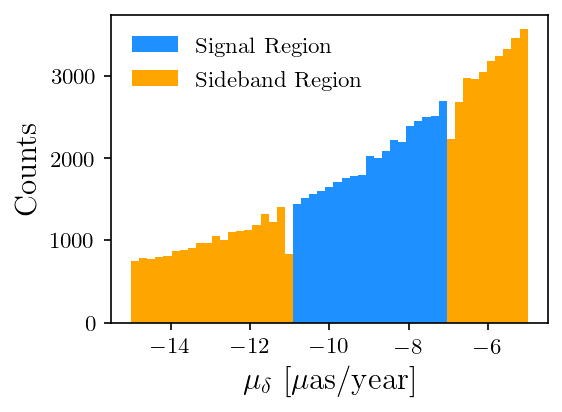

In [12]:
df_slice = signal_sideband(df, stream = stream)

# Train

In [13]:
tf.keras.backend.clear_session()

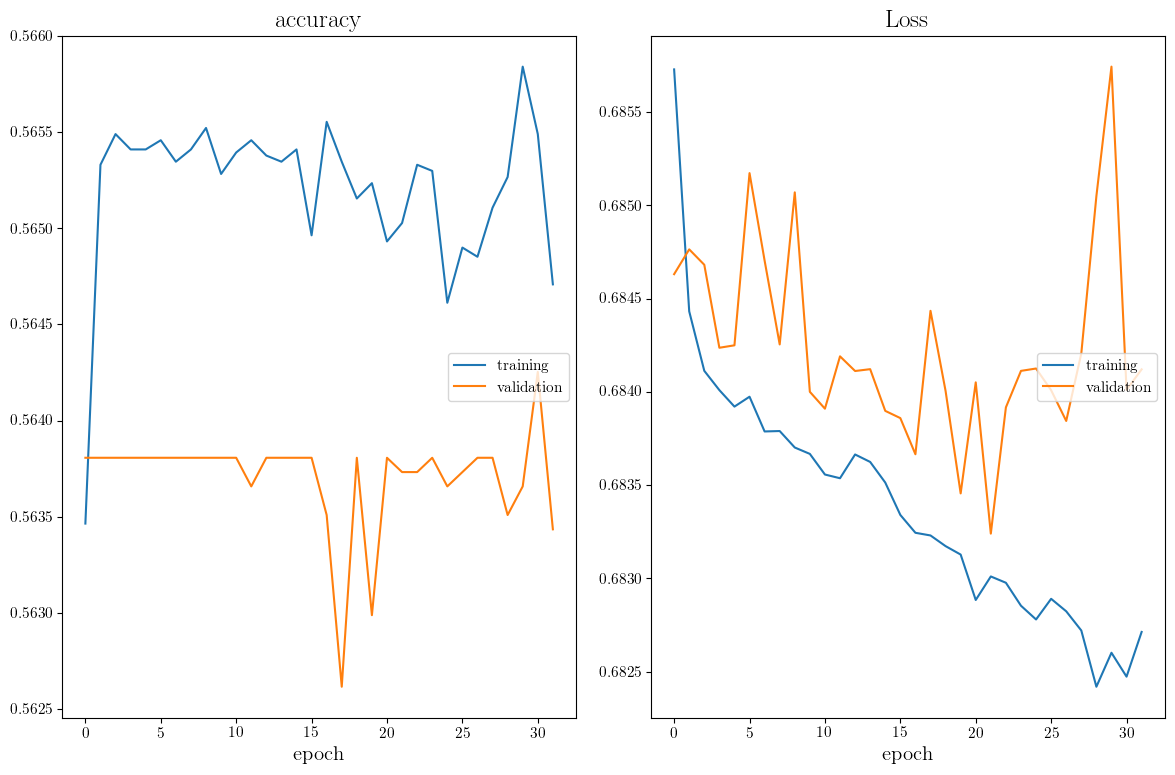

accuracy
	training         	 (min:    0.563, max:    0.566, cur:    0.565)
	validation       	 (min:    0.563, max:    0.564, cur:    0.563)
Loss
	training         	 (min:    0.682, max:    0.686, cur:    0.683)
	validation       	 (min:    0.683, max:    0.686, cur:    0.684)

Epoch 00032: val_loss did not improve from 0.68324
1960/1960 - 6s - loss: 0.6827 - accuracy: 0.5647 - val_loss: 0.6841 - val_accuracy: 0.5634
Epoch 00032: early stopping
AUC: 0.530
Maximum purity of 6.2% at 2.03%
Top 10 stars: Purity = 0.0% 
Top 100 stars: Purity = 3.0% 
Top 0.001% stars: Purity = 0.0% 
Top 0.01% stars: Purity = 0.0% 
Top 0.1% stars: Purity = 0.0% 
Top 1% stars: Purity = 5.2% 
Top 5% stars: Purity = 4.5% 
Top 10% stars: Purity = 3.3% 
Top 20% stars: Purity = 1.8% 


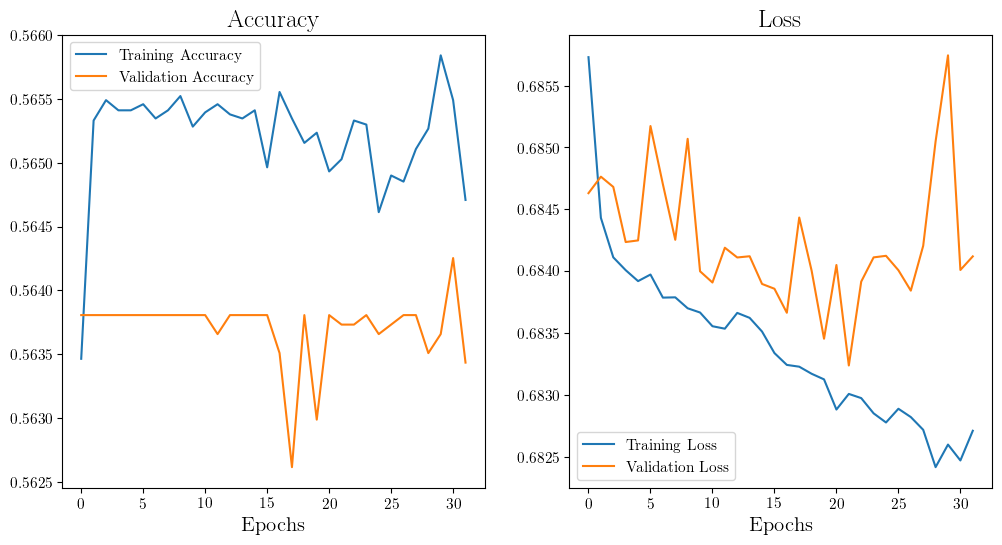

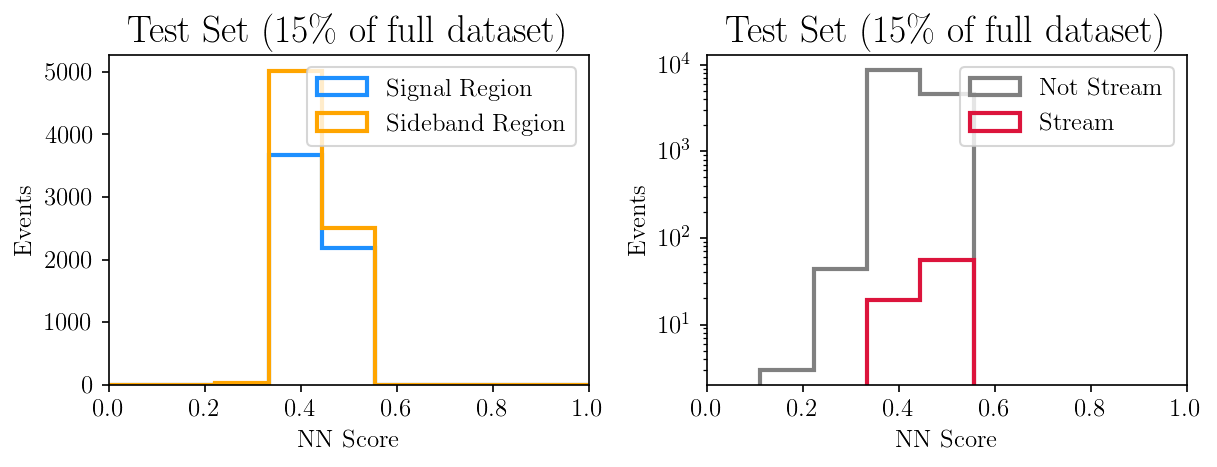

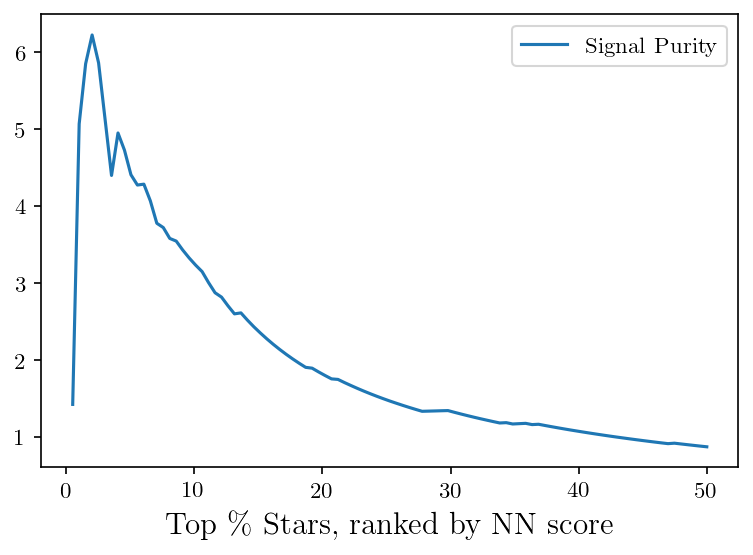

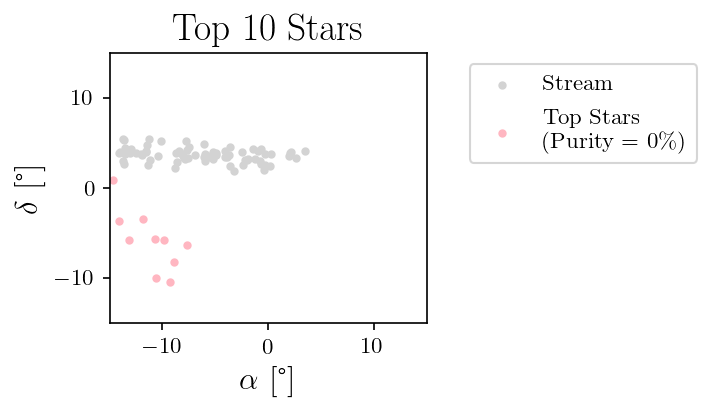

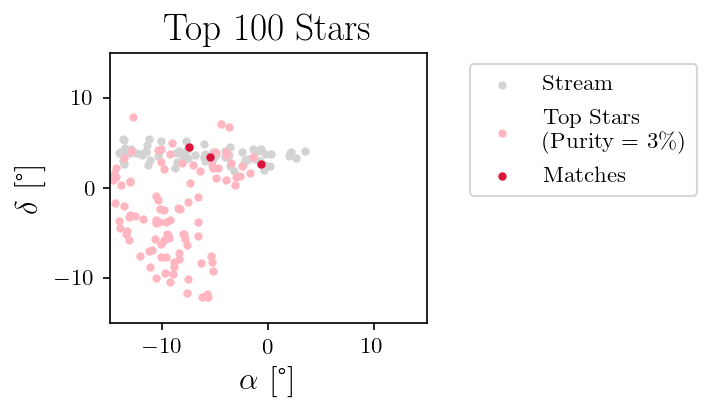

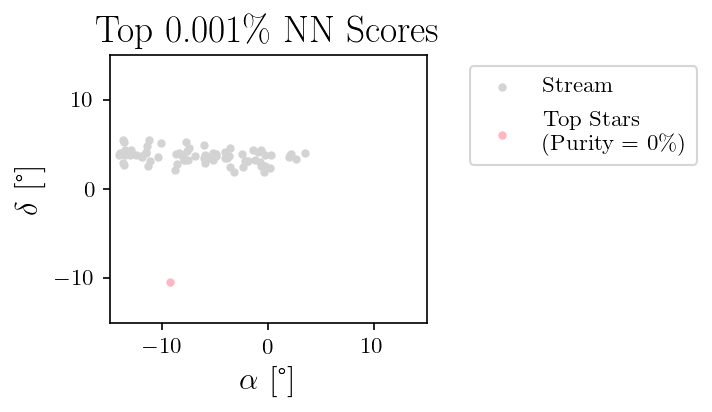

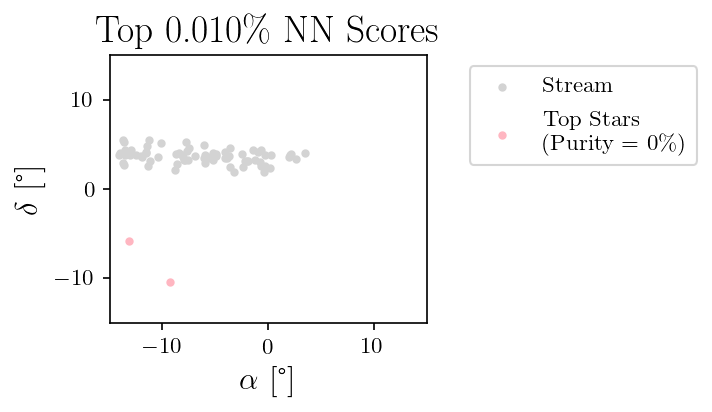

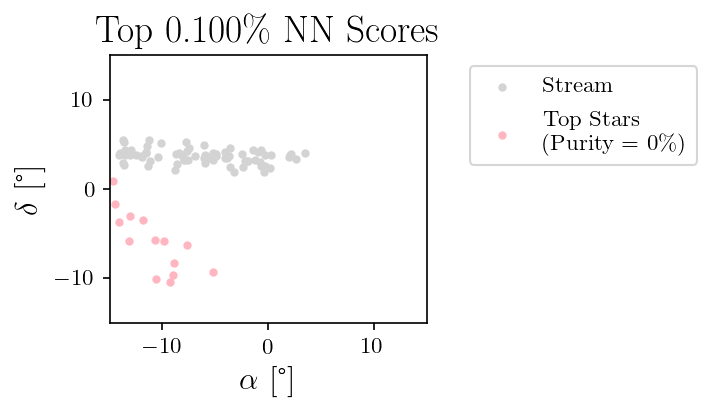

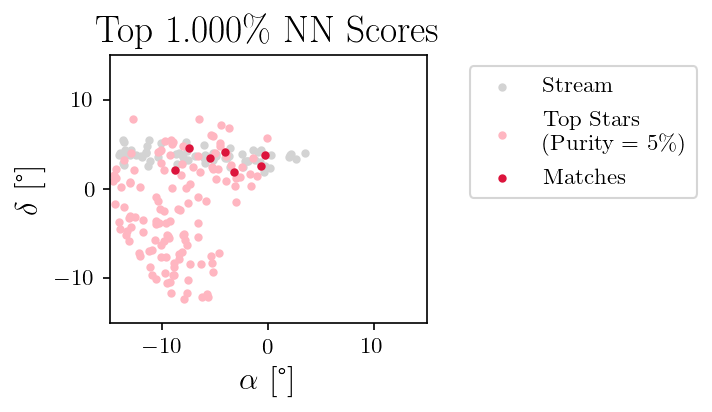

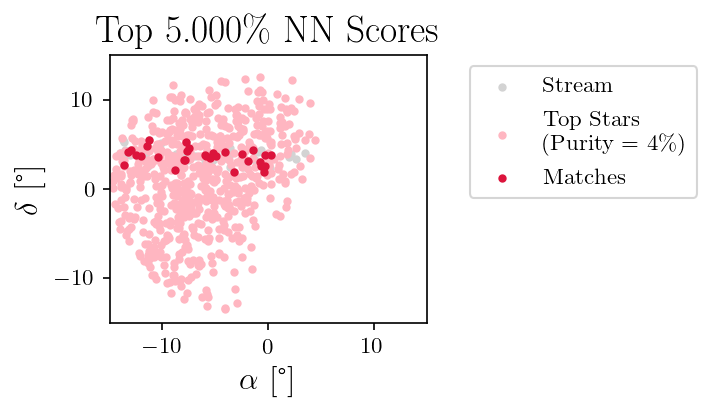

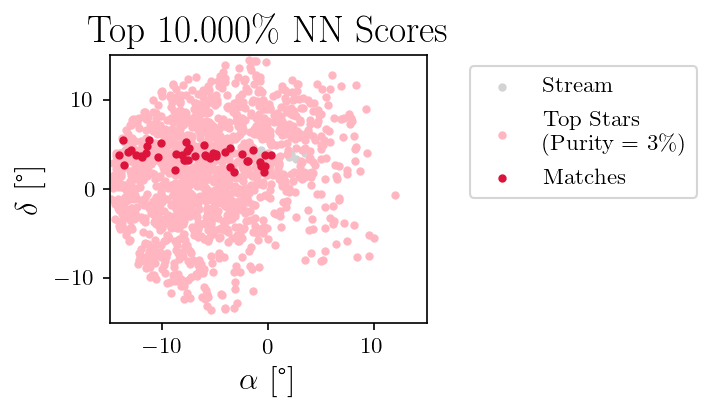

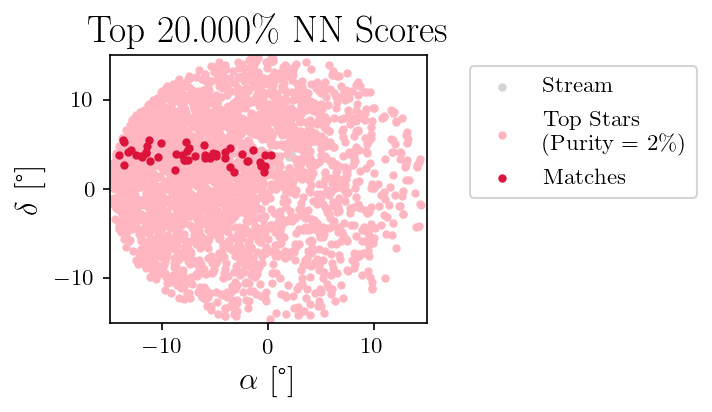

In [15]:
train(df_slice, epochs=50, layer_size=200, dropout=0.2, l2_reg=0, patience=10, n_folds=1)